In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.downloader as api
from gensim.models.fasttext import load_facebook_model
import random
from difflib import SequenceMatcher
from scipy import stats
import sacrebleu
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import spacy
import re
import edist.sed as sed
from sacremoses import MosesTokenizer, MosesDetokenizer
from sklearn.metrics import matthews_corrcoef

import sys  
sys.path.insert(0, '../')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


### Align different translations, find which words affect the translation of which words


**Note**: can use [sequence alignments](https://stackoverflow.com/questions/5055839/word-level-edit-distance-of-a-sentence) to align the sentences on the target side only. ([code](https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5))

Pros: could be easier than SRC-TGT alignment

Cons: in the case where more output different sentence structure yet same meaning. <br>
E.g., "Today I think the cat is nice" -- "I think the cat is nice today"
SRC-TGT alignment would probably see these as the same, but edit distance cannot, bc it only has del, insert, substitute operations.


Provided in functions `analyse_single_sentence_single_perturbed_word()` and  `analyse_single_sentence`

# Quality analysis

- Have to use WMT21 data, bc models for 2021 is available. Also they have clear evaluation script
- Have to do some manual fix so that the translation tokenization match completely with the tokenization of the labeled data

### Word-level

- A translated word is uncertain if changing other words in the SRC sentence affect its translations. The assumption is the the translation of one word should only depends on a few others word, but not too many.
    - E.g., My mother, who had a difficult childhood, is a great doctor.
    - The gender form of "doctor" should only change if we change the word "mother".

- Hyperparam: The number of SRC words that effect the translations of the target word
    - Currently: If a translated word has 3 or more effecting SRC word, mark as "BAD"

- Metrics: Matthews correlation coefficient 
    "It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction."
    
- Unsupervised baseline: since our approach is based on the uncertainty of a translated word, the baseline could be the word-level log probablity generated by the NMT model itself. (i.e., word with low certainty --> BAD)

Current score: 0.2825

Score of WMT21 shared task: baseline 0.370, best 0.510

WMT21 baseline: multilingual transformer-based Predictor-Estimator approach for both sentence level and word level


**How to do hyperparameter tuning if our goal is not to use the training data? Or just using the dev set is oke?**



### Baseline
Uses word-level log probablity generated by the NMT model itself. (i.e., word with low certainty --> BAD).

Note that the NMT model output subwords and subword log probs, so for a word `A=a1a2` made of subwords `a1`, `a2`:

prob(a1a2 | things before it, SRC) = prob(a1 | things before it, SRC) *  prob(a2 | a1, things before it, SRC) 

$$log(prob(A)) = log(prob(a1)) + log(prob(a2))$$




Some times it output subwords that contains 2 tokens (i.e., the opposite of the above case). This does not happen very often

Then we approximate:
$$log(prob(a1)) = log(prob(a2)) = log(prob(A))/2$$

**Is this correct???**



Current best hyperparams setting on dev en-de:

Our approach: hyperparams: 
- Perturbing [allTokens, allWords, allContentWords*]
- effecting_words_thresholds: [1,2*,3,4]
- consistence_trans_portion_thresholds: [0.6, 0.7, 0.8 0.85 0.9 0.95*]
- uniques_portion_for_noiseORperturbed_thresholds: [0.35 0.4* 0.45, 0.6, 0.8]

Nmt word probas:
- Thresholds [0.4, 0.45*, 0.5, 0.55, 0.6]

#### Word-level QE on translation

- Our perturbation approach:
    
- Use nmt model word probas:
    
    
    
#### Word-level QE on SRC
- Our perturbation approach:
    
- Use nmt model word probas:
    
    
--> Worse than using nmt model word probas

In [2]:
from align_and_analyse_ambiguous_trans import analyse_single_sentence_single_perturbed_word, analyse_single_sentence, align_translations, uniquify
from quality_estimation import nr_effecting_src_words_eval, nmt_log_prob_eval, flatten_list, load_gold_labels, replace_unknown, get_nmt_word_log_probs, get_nmt_word_log_probs_avg_perturbed

dataset = 'WMT21_DA_test'
data_root_path = '../data'
src_lang = 'en'
tgt_lang = 'de'

beam = 5
seed = 0
replacement_strategy = 'masking_language_model'
no_of_replacements = 30
mask_type = 'MultiplePerSentence_content'

effecting_words_threshold = 2
consistence_trans_portion_threshold = 0.95
uniques_portion_for_noiseORperturbed_threshold = 0.4
nmt_log_prob_threshold = 0.45
task = 'trans_word_level_eval'
perturbed_trans_df_path = f'../analyse_output/{dataset}_{src_lang}2{tgt_lang}_MultiplePerSentence_content/analyse_{dataset}_{src_lang}2{tgt_lang}_MultiplePerSentence_content.pkl'
original_translation_output_dir = f'../output/{dataset}_{src_lang}2{tgt_lang}/original'
perturbed_translation_output_dir = f'../output/{dataset}_{src_lang}2{tgt_lang}/{replacement_strategy}/beam{beam}_perturb{mask_type}/{no_of_replacements}replacements/seed{seed}'

alignment_tool = 'Tercom'

perturb_based_pred, perturb_based_details = nr_effecting_src_words_eval(perturbed_trans_df_path, task=task,
                                                 effecting_words_threshold=effecting_words_threshold,
                                                 consistence_trans_portion_threshold=consistence_trans_portion_threshold,
                                                 uniques_portion_for_noiseORperturbed_threshold=uniques_portion_for_noiseORperturbed_threshold,
                                                 return_details=True,
                                                 alignment_tool=alignment_tool)
nmt_prob_based_pred = nmt_log_prob_eval(dataset, data_root_path, src_lang, tgt_lang, nmt_log_prob_threshold, perturbed_trans_df_path, task,
                                        original_translation_output_dir)
gold_labels = load_gold_labels(dataset, data_root_path, src_lang, tgt_lang, task)




In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score, f1_score

def report_metrics(pred, gold_labels): 
    labels = ['OK', 'BAD']
    recall = recall_score(flatten_list(gold_labels), 
                          flatten_list(pred), labels=labels, pos_label='BAD')
    precision = precision_score(flatten_list(gold_labels), 
                                flatten_list(pred), labels=labels, pos_label='BAD')
    f1_bad = f1_score(flatten_list(gold_labels), 
                  flatten_list(pred), labels=labels, pos_label='BAD')
    f1_ok = f1_score(flatten_list(gold_labels), 
                  flatten_list(pred), labels=labels, pos_label='OK')

    print(f"Recall wrt BAD: {recall}")
    print(f"Precision wrt BAD: {precision}")
    print(f"F1 wrt BAD: {f1_bad}")
    print(f"F1 wrt OK: {f1_ok}")
    print(f"Matthews_corrcoef: {matthews_corrcoef(flatten_list(gold_labels), flatten_list(pred))}")

    print(f"Percentage of unknown labels: {accuracy_score(flatten_list(pred), ['unknown']*len(flatten_list(gold_labels)))*100}")

    dist = ConfusionMatrixDisplay(confusion_matrix(flatten_list(gold_labels), 
                                                   flatten_list(pred), labels=labels),
                                 display_labels=labels)
    dist.plot()



Recall wrt BAD: 0.45396317053642915
Precision wrt BAD: 0.31265508684863524
F1 wrt BAD: 0.3702857142857143
F1 wrt OK: 0.8530498723663656
Matthews_corrcoef: 0.23551405258725522
Percentage of unknown labels: 0.0


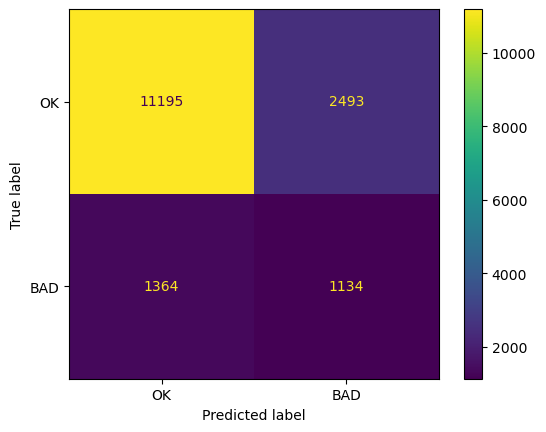

In [4]:
report_metrics(pred=nmt_prob_based_pred, gold_labels=gold_labels)

Recall wrt BAD: 0.5720576461168935
Precision wrt BAD: 0.3307104836843323
F1 wrt BAD: 0.4191230385687051
F1 wrt OK: 0.8449888467107579
Matthews_corrcoef: 0.2946319823713003
Percentage of unknown labels: 0.0


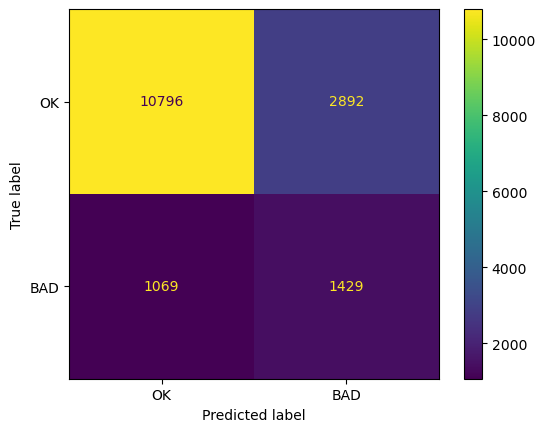

In [5]:
report_metrics(pred=perturb_based_pred, gold_labels=gold_labels)

Looking into the percentage of same predictions between `perturb_based_pred` and `nmt_prob_based_pred` to see if our approach is actually any different.

0.7021 --> actually detecting the same thing

In [7]:
accuracy_score(flatten_list(gold_labels), flatten_list(perturb_based_pred))

0.7552823427653528

Combinining the two classifiers:

Recall wrt BAD: 0.31945556445156126
Precision wrt BAD: 0.39602977667493794
F1 wrt BAD: 0.35364502548194104
F1 wrt OK: 0.8952941598765211
Matthews_corrcoef: 0.25228139462335963
Percentage of unknown labels: 0.0


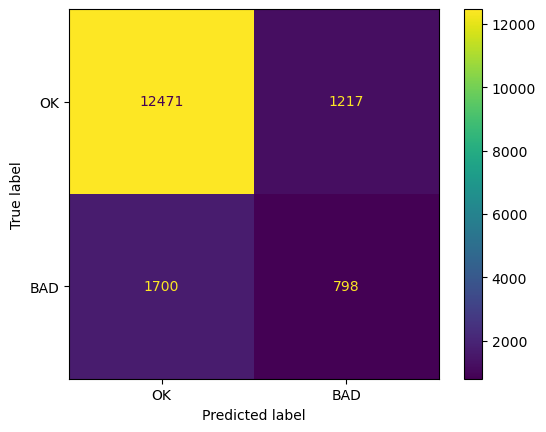

In [8]:
intersec_pred = [[
    'BAD' if i=='BAD' and j=='BAD' else
    'OK' if i=='OK' and j=='OK' else
    'OK' for i,j in zip(x,y)] 
    for x, y in zip(perturb_based_pred, nmt_prob_based_pred)]
 
report_metrics(pred=intersec_pred, gold_labels=gold_labels)

Recall wrt BAD: 0.7065652522017614
Precision wrt BAD: 0.29748862295634587
F1 wrt BAD: 0.4186929189894437
F1 wrt OK: 0.7952884173593417
Matthews_corrcoef: 0.30143924152318785
Percentage of unknown labels: 0.0


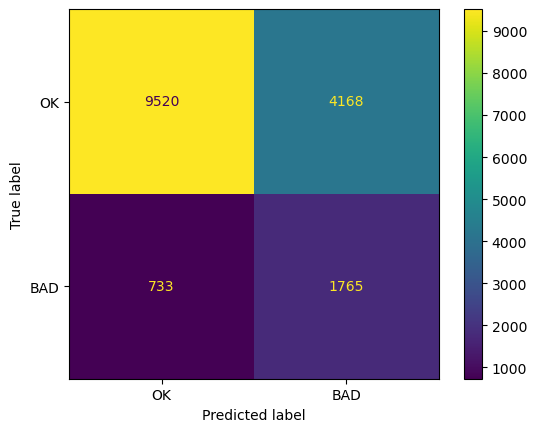

In [9]:
union_pred = [[
    'BAD' if i=='BAD' and j=='BAD' else
    'OK' if i=='OK' and j=='OK' else
    'BAD' for i,j in zip(x,y)] 
    for x, y in zip(perturb_based_pred, nmt_prob_based_pred)]
 
report_metrics(pred=union_pred, gold_labels=gold_labels)

In [11]:
perturbed_trans_df = pd.read_pickle(perturbed_trans_df_path)

Use our method to output a confidence score instead of binary OK/BAD. Result not as good as the current setting.

Recall wrt BAD: 0.5360288230584468
Precision wrt BAD: 0.32476352170749456
F1 wrt BAD: 0.404470623772844
F1 wrt OK: 0.8468797328259096
Matthews_corrcoef: 0.2758068451896569
Percentage of unknown labels: 0.0


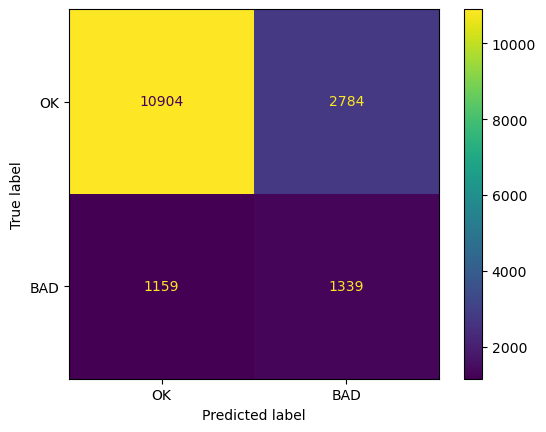

In [12]:
prob_pred = []
for sentence_i in range(len(perturb_based_details)):
    prob_pred_per_sentence = []
    for word_i in range(len(perturb_based_details[sentence_i])):
        sentence_df = perturbed_trans_df[perturbed_trans_df['SRC_original_idx'] == sentence_i]
        original_src_length = len(sentence_df['tokenized_SRC'].values[0])
        
        nr_effecting_src = len(perturb_based_details[sentence_i][word_i]['effecting_words'])
        nr_no_effecting_src = len(perturb_based_details[sentence_i][word_i]['no_effecting_words'])
        
        prob = (nr_no_effecting_src - nr_effecting_src) / (original_src_length - 1)
        
        prob_pred_per_sentence.append(prob)
    prob_pred.append(prob_pred_per_sentence)
        
label_pred = [['BAD' if x < 0.2 else 'OK' for x in y] for y in prob_pred]

report_metrics(pred=label_pred, gold_labels=gold_labels)
        

Ensemble (average) our confidence score with the nmt log prob score:

In [13]:
nmt_log_prob = get_nmt_word_log_probs(dataset, data_root_path, src_lang, tgt_lang, original_translation_output_dir)
nmt_prob = [[2**x for x in y] for y in nmt_log_prob]

Recall wrt BAD: 0.6180944755804644
Precision wrt BAD: 0.32573839662447257
F1 wrt BAD: 0.42663719259463945
F1 wrt OK: 0.8348850163125647
Matthews_corrcoef: 0.3053271505877078
Percentage of unknown labels: 0.0


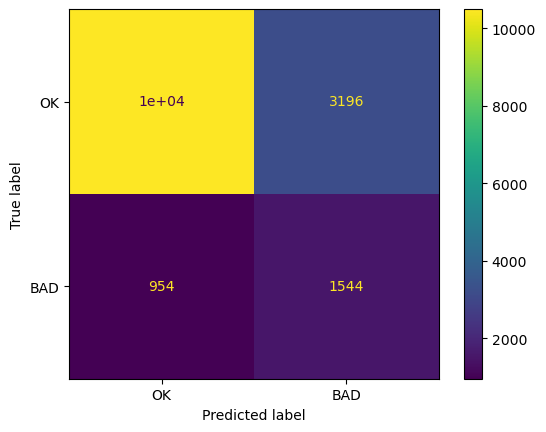

In [14]:
ensemble_prob = [[(x+y)/2 for x, y in zip(m,n)] for m,n in zip(prob_pred, nmt_prob)]
ensemble_label = [['BAD' if x < 0.4 else 'OK' for x in y] for y in ensemble_prob]
report_metrics(pred=ensemble_label, gold_labels=gold_labels)


**Result**: 

- Confidence ensemble (this is already tuned to the test set):
```
Recall wrt BAD: 0.6180944755804644
Precision wrt BAD: 0.32573839662447257
F1 wrt BAD: 0.42663719259463945
F1 wrt OK: 0.8348850163125647
Matthews_corrcoef: 0.3053271505877078
Percentage of unknown labels: 0.0
```

- Simple union ensemble (tuned to dev set):
```
Recall wrt BAD: 0.7065652522017614
Precision wrt BAD: 0.29748862295634587
F1 wrt BAD: 0.4186929189894437
F1 wrt OK: 0.7952884173593417
Matthews_corrcoef: 0.30143924152318785
Percentage of unknown labels: 0.0
```

Confidence ensemble is a bit better but not significantly better.

Also ensemble score is not significantly better than our approach alone:
```
Recall wrt BAD: 0.5720576461168935
Precision wrt BAD: 0.3307104836843323
F1 wrt BAD: 0.4191230385687051
F1 wrt OK: 0.8449888467107579
Matthews_corrcoef: 0.2946319823713003
Percentage of unknown labels: 0.0
```
and it makes we looose the blackbox power --> skip ensemble?

### Average probs from the perturbations

In [15]:
avg_nmt_log_prob = get_nmt_word_log_probs_avg_perturbed(dataset, data_root_path, src_lang, tgt_lang, 
                                                        original_translation_output_dir, 
                                                        perturbed_translation_output_dir, 
                                                        perturbed_trans_df_path,
                                                        alignment_tool='Tercom')
avg_nmt_prob = [[2**x for x in y] for y in avg_nmt_log_prob]


Recall wrt BAD: 0.4175340272217774
Precision wrt BAD: 0.3275753768844221
F1 wrt BAD: 0.3671242520239352
F1 wrt OK: 0.8652678905957288
Matthews_corrcoef: 0.2373089727042531
Percentage of unknown labels: 0.0


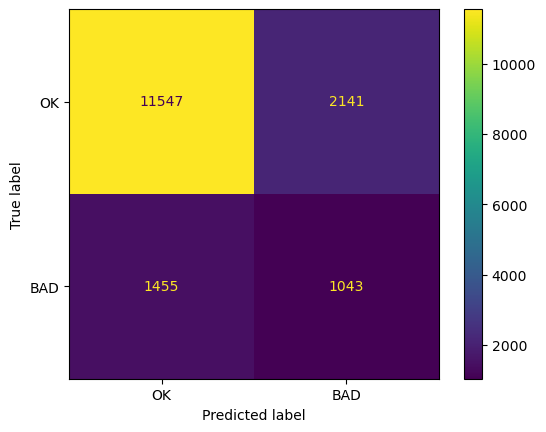

In [16]:
avg_nmt_label = [['BAD' if x < 0.45 else 'OK' for x in y] for y in avg_nmt_prob]
report_metrics(pred=avg_nmt_label, gold_labels=gold_labels)

Recall wrt BAD: 0.5944755804643715
Precision wrt BAD: 0.3202501617425059
F1 wrt BAD: 0.41625788367203925
F1 wrt OK: 0.8349645361968537
Matthews_corrcoef: 0.2910157380838903
Percentage of unknown labels: 0.0


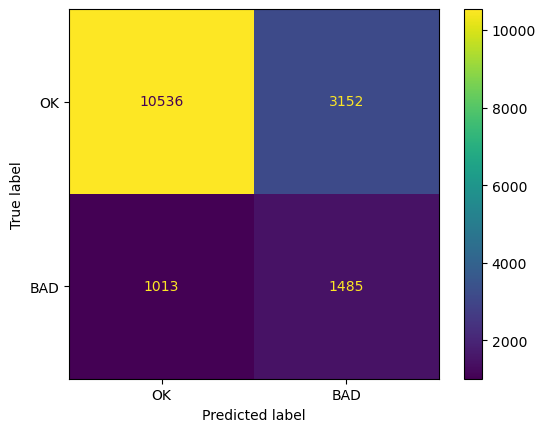

In [22]:
ensemble_prob = [[(x+y)/2 for x, y in zip(m,n)] for m,n in zip(prob_pred, avg_nmt_prob)]
ensemble_label = [['BAD' if x < 0.4 else 'OK' for x in y] for y in ensemble_prob]
report_metrics(pred=ensemble_label, gold_labels=gold_labels)

In [18]:
accuracy_score(flatten_list(nmt_prob_based_pred), flatten_list(avg_nmt_label))

0.9411219572470035

Not much difference from using only the prob of the original translation.

### Analyse some specific samples

In [24]:
perturbed_trans_df = pd.read_pickle(perturbed_trans_df_path)


In [37]:
stop = 5
count = 0
for sentence_idx in range(len(gold_labels)):
    sentence_df = perturbed_trans_df[perturbed_trans_df['SRC_original_idx'] == sentence_idx]
    original_SRC = sentence_df['SRC'].values[0]
    original_translation = sentence_df['SRC-Trans'].values[0]
    tok_original_translation = sentence_df['tokenized_SRC-Trans'].values[0]
    tok_original_SRC = sentence_df['tokenized_SRC'].values[0]

    my_pred = np.array(perturb_based_pred[sentence_idx])
    nmt_pred = np.array(nmt_prob_based_pred[sentence_idx])
    gold = np.array(gold_labels[sentence_idx])


#     # BAD words correctly predicted by perturb_based_pred
#     bad_word_indices = np.nonzero(np.logical_and(my_pred=='BAD', gold=='BAD'))

#     # OK words predicted by perturb_based_pred as BAD
#     bad_word_indices = np.nonzero(np.logical_and(my_pred=='BAD', gold=='OK'))
    
    # BAD words predicted by perturb_based_pred as OK
    bad_word_indices = np.nonzero(np.logical_and(my_pred=='OK', gold=='BAD'))


    # # BAD words correctly predicted by perturb_based_pred, but not by nmt_prob_based_pred
    # bad_word_indices = np.nonzero(np.logical_and(np.logical_and(my_pred=='BAD', gold=='OK'), gold=='BAD'))
    
    if len(bad_word_indices[0]) > 0:
        
        print(len(bad_word_indices[0]))
        count = count + 1
        if count == stop:
            word_idx = bad_word_indices[0][0]
            break



1
3
4
3
3


In [29]:
sentence_idx = 332
sentence_df = perturbed_trans_df[perturbed_trans_df['SRC_original_idx'] == sentence_idx]
original_SRC = sentence_df['SRC'].values[0]
original_translation = sentence_df['SRC-Trans'].values[0]
tok_original_translation = sentence_df['tokenized_SRC-Trans'].values[0]
tok_original_SRC = sentence_df['tokenized_SRC'].values[0]
my_pred = np.array(perturb_based_pred[sentence_idx])
bad_word_indices = np.nonzero(my_pred=='BAD')
word_idx = bad_word_indices[0][2]

In [30]:
bad_word_indices

(array([ 4, 15, 16]),)

In [31]:
if task == 'src_word_level_eval':
    word = tok_original_SRC[word_idx]
    align_type = "src-trans"
elif task == 'trans_word_level_eval':
    word = tok_original_translation[word_idx]
    align_type = "trans-only"
else:
    raise RuntimeError()

In [32]:
import pprint


print(f"Original SRC sentence:\n{original_SRC}")
print(f"Original trans:\n{original_translation}")
print(f"BAD word: {word}")
print()

pprint.pprint(analyse_single_sentence(
    sentence_df, align_type=align_type, return_word_index=False,
    consistence_trans_portion_threshold=consistence_trans_portion_threshold,
    uniques_portion_for_noiseORperturbed_threshold=uniques_portion_for_noiseORperturbed_threshold,
    alignment_tool=alignment_tool
)[word])


Original SRC sentence:
Carter fared particularly well in the Northeast and the South, while Ford swept the West and won much of the Midwest.
Original trans:
CARTER ging es besonders gut im Nordosten und Süden , während Ford fegte den Westen und gewann einen Großteil des Mittleren Westens .
BAD word: gewann

{'effecting_words': ['Carter',
                     'fared',
                     'particularly',
                     'well',
                     'Northeast',
                     'South',
                     'Ford',
                     'swept',
                     'West',
                     'much',
                     'Midwest'],
 'no_effecting_words': []}


In [33]:
original_word = 'fared'


groups_by_perturbed_word = sentence_df.groupby("SRC_masked_index", as_index=False)
original_words = [group_by_perturbed_word.iloc[0]['original_word']
                  for _, group_by_perturbed_word in groups_by_perturbed_word]
groups_by_perturbed_word = [group_by_perturbed_word for _, group_by_perturbed_word in groups_by_perturbed_word]
original_words = list(uniquify(original_words))


sentence_single_perturbed_word_df = groups_by_perturbed_word[original_words.index(original_word)]


pprint.pprint(analyse_single_sentence_single_perturbed_word(
    sentence_single_perturbed_word_df, align_type=align_type,
    consistence_trans_portion_threshold=consistence_trans_portion_threshold,
    uniques_portion_for_noiseORperturbed_threshold=uniques_portion_for_noiseORperturbed_threshold,
    alignment_tool=alignment_tool
))
align_translations(sentence_single_perturbed_word_df, align_type=align_type, alignment_tool=alignment_tool)


{'perturbed_or_noise_words': ['ging', 'es'],
 'words_with_consistent_trans': {',': ',',
                                 '.': '.',
                                 'Carter': 'Carter',
                                 'Ford': 'Ford',
                                 'Großteil': 'Großteil',
                                 'Mittleren': 'Mittleren',
                                 'Nordosten': 'Nordosten',
                                 'Süden': 'Süden',
                                 'Westen': 'Westen',
                                 'Westens': 'Westens',
                                 'den': 'den',
                                 'des': 'des',
                                 'einen': 'einen',
                                 'fegte': 'fegte',
                                 'im': 'im',
                                 'und': 'und',
                                 'während': 'während'},
 'words_with_unstable_trans': {'besonders': {'besonders': 29,
                           

,Carter,ging,es,besonders,gut,im,Nordosten,und,Süden,",",während,Ford,fegte,den,Westen,und_2,gewann,einen,Großteil,des,Mittleren,Westens,.
fared,Carter,ging,es,besonders,gut,im,Nordosten,und,Süden,",",während,Ford,fegte,den,Westen,und,gewann,einen,Großteil,des,Mittleren,Westens,.
did,Carter,<NA>,verlief,besonders,gut,im,Nordosten,und,Süden,",",während,Ford,<NA>,den,Westen,fegte,und,einen,Großteil,des,Mittleren,Westens,.
performed,Carter,<NA>,verlief,besonders,gut,im,Nordosten,und,Süden,",",während,Ford,<NA>,den,Westen,fegte,und,einen,Großteil,des,Mittleren,Westens,.
won,Carter,<NA>,gewann,besonders,gut,im,Nordosten,und,Süden,",",<NA>,Ford,fegte,den,Westen,und,gewann,einen,Großteil,des,Mittleren,Westens,.
ran,Carter,<NA>,lief,besonders,gut,im,Nordosten,und,Süden,",",während,Ford,fegte,den,Westen,und,gewann,einen,Großteil,des,Mittleren,Westens,.
played,Carter,<NA>,spielte,besonders,gut,im,Nordosten,und,Süden,",",während,Ford,<NA>,den,Westen,fegte,und,einen,Großteil,des,Mittleren,Westens,.
scored,<NA>,Besonders,gut,punktete,Carter,im,Nordosten,und,Süden,",",während,Ford,<NA>,den,Westen,fegte,und,einen,Großteil,des,Mittleren,Westens,.
finished,Carter,<NA>,beendete,besonders,gut,im,Nordosten,und,Süden,",",während,Ford,<NA>,den,Westen,fegte,und,einen,Großteil,des,Mittleren,Westens,.
campaigned,Carter,<NA>,kämpfte,besonders,gut,im,Nordosten,und,Süden,",",während,Ford,<NA>,den,Westen,fegte,und,einen,Großteil,des,Mittleren,Westens,.
started,Carter,<NA>,begann,besonders,gut,im,Nordosten,und,Süden,",",während,Ford,fegte,den,Westen,und,gewann,einen,Großteil,des,Mittleren,Westens,.


In [34]:
sentence_single_perturbed_word_df.head()

,SRC,original_word,perturbed_word,SRC_perturbed,SRC-Trans,SRC_perturbed-Trans,SRC_original_idx,SRC_masked,original_word_tag,SRC_masked_index,Replacement rank,tokenized_SRC_perturbed,tokenized_SRC_perturbed-Trans,perturbed_trans_alignment,perturbed_trans_alignment_index,tokenized_SRC,tokenized_SRC-Trans,original_trans_alignment,original_trans_alignment_index,opcodes,changes,SRC-edit_distance,Trans-edit_distance,#TransChanges/SentenceLength,Trans-edit_distance--SD,ChangesSpread,ChangesSpread/SentenceLength
92730,"Carter fared particularly well in the Northeast and the South, while Ford swept the West and won much of the Midwest.",fared,did,"Carter did particularly well in the Northeast and the South, while Ford swept the West and won much of the Midwest.","Carter GING ES besonders gut im Nordosten und Süden , während Ford FEGTE den Westen und GEWANN einen Großteil des Mittleren Westens .","Carter VERLIEF besonders gut im Nordosten und Süden , während Ford den Westen FEGTE und einen Großteil des Mittleren Westens GEWANN .",332,"Carter [MASK] particularly well in the Northeast and the South, while Ford swept the West and won much of the Midwest.",VBD,3091,1,"[Carter, did, particularly, well, in, the, Northeast, and, the, South, ,, while, Ford, swept, the, West, and, won, much, of, the, Midwest, .]","[Carter, verlief, besonders, gut, im, Nordosten, und, Süden, ,, während, Ford, den, Westen, fegte, und, einen, Großteil, des, Mittleren, Westens, gewann, .]","{'Carter': 'Carter', 'did': 'verlief', 'particularly': 'besonders', 'well': 'gut', 'in': 'im', 'Northeast': 'Nordosten', 'and': 'und', 'South': 'Süden', ',': ',', 'while': 'während', 'Ford': 'Ford', 'swept': 'fegte', 'the': 'den', 'West': 'Westen', 'won': 'gewann', 'much': 'Großteil', 'of': 'des', 'Midwest': 'Westens', '.': '.'}","{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5, 7: 6, 9: 7, 10: 8, 11: 9, 12: 10, 13: 13, 14: 11, 15: 12, 16: 14, 17: 20, 18: 16, 19: 17, 21: 19, 22: 21}","[Carter, fared, particularly, well, in, the, Northeast, and, the, South, ,, while, Ford, swept, the, West, and, won, much, of, the, Midwest, .]","[Carter, ging, es, besonders, gut, im, Nordosten, und, Süden, ,, während, Ford, fegte, den, Westen, und, gewann, einen, Großteil, des, Mittleren, Westens, .]","{'Carter': 'Carter', 'fared': 'ging', 'particularly': 'besonders', 'well': 'gut', 'in': 'im', 'Northeast': 'Nordosten', 'and': 'und', 'South': 'Süden', ',': ',', 'while': 'während', 'Ford': 'Ford', 'swept': 'fegte', 'the': 'den', 'West': 'Westen', 'won': 'gewann', 'much': 'Großteil', 'of': 'des', 'Midwest': 'Westens', '.': '.'}","{0: 0, 1: 1, 2: 3, 3: 4, 4: 5, 6: 6, 7: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 18, 19: 19, 21: 21, 22: 22}","[(equal, 0, 1, 0, 1), (replace, 1, 3, 1, 2), (equal, 3, 12, 2, 11), (delete, 12, 13, 11, 11), (equal, 13, 15, 11, 13), (insert, 15, 15, 13, 14), (equal, 15, 16, 14, 15), (delete, 16, 17, 15, 15), (equal, 17, 22, 15, 20), (insert, 22, 22, 20, 21), (equal, 22, 23, 21, 22)]","[(replace, ging es, verlief), (delete, fegte, ), (insert, , fegte), (delete, gewann, ), (insert, , gewann)]",1,6,0.260870,NaN,21,0.913043
92731,"Carter fared particularly well in the Northeast and the South, while Ford swept the West and won much of the Midwest.",fared,performed,"Carter performed particularly well in the Northeast and the South, while Ford swept the West and won much of the Midwest.","Carter GING ES besonders gut im Nordosten und Süden , während Ford FEGTE den Westen und GEWANN einen Großteil des Mittleren Westens .","Carter VERLIEF besonders gut im Nordosten und Süden , während Ford den Westen FEGTE und einen Großteil des Mittleren Westens GEWANN .",332,"Carter [MASK] particularly well in the Northeast and the South, while Ford swept the West and won much of the Midwest.",VBD,3091,2,"[Carter, performed, particularly, well, in, the, Northeast, and, the, South, ,, while, Ford, swept, the, West, and, won, much, of, the, Midwest, .]","[Carter, verlief, besonde

### Finding patterns

In [23]:
from collections import defaultdict

bad_word_dict = defaultdict(lambda: {'freq': 0, 'sentence_idxs': [], 'effecting_SRC_words': []})  # bad_word: {'freq': freq, 'effecting_SRC_words': list}

all_words = []

for sentence_idx in range(len(gold_labels)):
    sentence_df = perturbed_trans_df[perturbed_trans_df['SRC_original_idx'] == sentence_idx]
    tok_original_translation = sentence_df['tokenized_SRC-Trans'].values[0]
    all_words.append(tok_original_translation)
    
for sentence_idx in range(len(gold_labels)):
    for word_idx in range(len(gold_labels[sentence_idx])):
        # Only considers the correctly predicted BAD ones
        if perturb_based_pred[sentence_idx][word_idx] == 'BAD' and gold_labels[sentence_idx][word_idx] == 'BAD':
            bad_word = all_words[sentence_idx][word_idx]
            bad_word_dict[bad_word]['freq'] = bad_word_dict[bad_word]['freq'] + 1
            bad_word_dict[bad_word]['sentence_idxs'].append(sentence_idx)
            bad_word_dict[bad_word]['effecting_SRC_words'].extend(
                perturb_based_details[sentence_idx][word_idx]['effecting_words']
            )


In [24]:
from collections import Counter

def list_to_frequency(a_list):
    """ ['a', 'a', 'a', 'b', 'b'] --> {'a': 3, 'b': 2}
    """
    return dict(Counter(a_list).most_common())
    

In [25]:
bad_word_df = pd.DataFrame(bad_word_dict).transpose().sort_values(by='freq', ascending=False)
bad_word_df['effecting_SRC_words'] = bad_word_df['effecting_SRC_words'].apply(lambda x: list_to_frequency(x))

Filter out the functional words (only keep 'NOUN', 'VERB', 'ADJ', 'PRON')

In [26]:
def tgt_word_pos_tag(word, spacy_model):
    doc = spacy_model(word)
    return doc[0].pos_

def is_content_tag(spacy_tag):
    if spacy_tag in ['NOUN', 'VERB', 'ADJ', 'PRON']:
        return True
    return False
    

In [27]:
spacy_model = spacy.load("de_core_news_sm")
pattern_df = \
    bad_word_df[bad_word_df.index.to_series().apply(lambda x: is_content_tag(tgt_word_pos_tag(x, spacy_model)))]



In [35]:
pattern_df.head()

,freq,sentence_idxs,effecting_SRC_words
sie,8,"[20, 21, 760, 796, 806, 841, 841, 971]","{'involve': 2, 'throwing': 2, 'it': 2, 'Harpies': 1, 'lair': 1, 'boat': 1, 'destroys': 1, 'merged': 1, 'competitor': 1, 'Hawke': 1, 'form': 1, 'Coachwork_2': 1, 'International': 1, 'Together': 1, 'nystagmus': 1, 'intention': 1, 'tremor': 1, 'triad': 1, 'Mughals': 1, 'recognized': 1, 'Mughal': 1, 'Possessive': 1, 'determiners': 1, 'are': 1, 'not': 1, 'inflected': 1, 'used': 1, 'adjectives': 1, 'it_2': 1, 'Angry': 1, 'Sienna': 1, 'betrayed': 1, 'Sienna_2': 1}"
einer,7,"[128, 205, 302, 784, 803, 882, 949]","{'duel': 1, 'Denshichirō': 1, 'begins': 1, 'Ueda': 1, 'draws': 1, 'matchlock': 1, 'Musashi': 1, 'dispatches': 1, 'his': 1, 'weapon': 1, 'accosted': 1, 'Heyman_2': 1, 'threatened': 1, 'lawsuit': 1, 'hangs': 1, 'our': 1, 'greatest': 1, 'Olympians': 1, 'ship': 1, 'belonging': 1, 'race': 1, 'weakening': 1, 'further': 1, 'depression': 1, 'Winnie': 1, 'sexual': 1, 'lead': 1, 'pipe': 1, 'skull': 1, 'second': 1, 'innings': 1, 'quick': 1, 'wickets': 1, 'hosts': 1, 'slumped': 1, 'recovery': 1}"
s,5,"[27, 199, 311, 893, 901]","{'Digitalis': 1, 'Ryan': 1, 'name': 1, 'safely': 1, 'landed': 1, 'first': 1, 'dawn': 1, 'splashdown': 1, 'recovery': 1, 'Claudia': 1, 'learns': 1, 'whereabouts': 1, 'attempts': 1, 'real': 1, 'eventually': 1, 'confronted': 1, 'fake': 1, 'managed': 1, 'pilfer': 1, 'bag': 1, 'regiment': 1, 'rejoined': 1, 'Army': 1, 'Lt.': 1, 'Ulysses': 1, 'Grant': 1, 'Overland': 1, 'Campaign': 1}"
sich,5,"[14, 61, 580, 840, 861]","{'Steve': 1, 'then': 1, 'they': 1, 'plummet': 1, 'policy': 1, 'Indian': 1, 'India': 1, 'Scattered': 1, 'tornadoes': 1, 'state': 1, 'Texas': 1, 'February': 1, 'opting': 1, 'his': 1, 'comrade': 1, 'Trace': 1, 'essences': 1, 'Horrors': 1, 'latch': 1, 'Makai': 1, 'Knight': 1, 'accumulate': 1, 'requiring': 1, 'him': 1, 'ritualistic': 1, 'purification': 1, 'periodically': 1}"
Regiment,4,"[243, 243, 243, 566]","{'It': 3, 'comprised': 3, 'Battalion': 3, 'Parachute': 3, 'Battalion_2': 3, 'Parachute_2': 3, 'Regiment_2': 2, 'Regiment_3': 2, 'Regiment': 2, 'Parachute_3': 1, 'transferred': 1, 'newly': 1, 'Mechanised': 1, 'Infantry': 1}"


## Sentence level

Approximations:
- Negative corr with DA:
    - Changes edit distance 
    - Changes edit distance / length
    - Changes spread
    - Changes spread / length
    - Number of BAD tokens
   
Metrics: Pearson correlation coefficient: "Correlations of -1 or +1 imply an exact linear relationship"

DA scores:
Scores: highest 0.18
WMT21 scores: baseline 0.403, best 0.584


HTER scores: 
Scores: highest 0.28
WMT21 scores: baseline 0.529, best 0.653

**Can try to apply some function to the prediction, but then that's not unsupervised anymore**

**Can use as feature for QE model, but again not unsupervised anymore**

In [ ]:
from scipy.stats import zscore
from scipy.stats import pearsonr, spearmanr


approximations = output[
    ["SRC_original_idx", 
     "Trans-edit_distance", 
     "#TransChanges/SentenceLength",
     "ChangesSpread",
     "ChangesSpread/SentenceLength"
    ]
].groupby("SRC_original_idx").mean()

approximations['word_level_agg'] = [x.count('BAD') for x in word_tag]


for col in approximations.columns:
    # Normalize the apporximations, invert the sign
    approximations[col] = -approximations[col]
    approximations[col] = zscore(approximations[col].values)
    
    
approximations.head()

In [ ]:
# trans_analysed_file = "analyse_WMT22_MQM_en2de.pkl"
# output = pd.read_pickle(trans_analysed_file)

Gold labels:

In [ ]:
if 'WMT21_DA' in trans_analysed_file:
    with open("../data/wmt-qe-2021-data/en-de-test21/goldlabels/test21.hter", 'r') as f:
        da_scores = f.readlines()
        da_scores = [float(da_score.replace('\n', '')) for da_score in da_scores]
    gold_lables = da_scores
elif 'WMT22_MQM' in trans_analysed_file:
    with open("../data/wmt-qe-2022-data/test_data-gold_labels/task1_mqm/en-de/test.2022.en-de.mqm_z_score", 'r') as f:
        mqm_scores = f.readlines()
        mqm_scores = [float(mqm_score.replace('\n', '')) for mqm_score in mqm_scores]
    gold_lables = mqm_scores

    

Evaluation on gold labels:

In [ ]:
for col in approximations.columns:
    print(f"-----------------{col}-----------------")
    print(pearsonr(gold_lables, approximations[col].values))


In [ ]:
for col in approximations.columns:
    plot_df = pd.DataFrame({'true': gold_lables, 'pred': approximations[col].values})
#     plot_df = plot_df.sort_values('pred')
    
    X = plot_df['pred']
    Y = plot_df['true']
    
    plt.figure()
    hist = plt.hist(Y, bins=20)
    bin_boundaries = hist[1]
    
#     # Remove bins with too few samples
#     cut_point = 99999
#     for i, value in enumerate(hist[0]):
#         if value < 5:
#             cut_point = i
#             break

#     bin_boundaries = bin_boundaries[:cut_point]
    
    
    plt.figure()
    x_plot = [(bin_boundaries[i] + bin_boundaries[i+1])/2 for i in range(0, len(bin_boundaries)-1)]
    y_plot = [stats.trim_mean(Y[(bin_boundaries[i] < X) & (X < bin_boundaries[i+1])], 0.1) for i in range(0, len(bin_boundaries)-1)]
    plt.plot(x_plot, y_plot)
    plt.xlabel(col)
    plt.ylabel('gold_lables')


    
    

In [ ]:
trans_analysed_file = "tmp_storages/analyse_WMT21_DA_dev_en2de_MultiplePerSentence_allWords.pkl"
output = pd.read_pickle(trans_analysed_file)

# original_src_errornous_idxs = [17, 122, 306, 817, 908, 940]


def fix_tokenization(tokenized_sentence, dataset):
    # Only for WMT21_DA_en2de data
    # Some of the sentences is tokenized differently in the labeled data. I.e., the last dot is not tokenized
    # Fix in order to syncronize with the labeled data
    if tokenized_sentence[-1] != '.':
        str_sentence = ' '.join(tokenized_sentence)
        str_sentence = str_sentence[:-1] + ' .'
        return str_sentence.split()
    else:
        return tokenized_sentence

# output['tokenized_SRC'] = output.apply(
#                 lambda x: fix_tokenization(
#                     x['tokenized_SRC']
#                 ) if x['SRC_original_idx'] in original_src_errornous_idxs else x['tokenized_SRC'],
#                 axis=1
#             )


toks = output.groupby('SRC_original_idx').first()['tokenized_SRC'].tolist()
toks = [' '.join(tok) for tok in toks]

with open('/Users/tuanh/Desktop/tmp.txt', 'w') as f:
    for x in toks:
        f.writelines(x + '\n')


In [ ]:
for i, j in zip(x, y):
    print(i, j)